# Homework 8: Principal Component Analysis & Boosting

In this homework we will implement the Principal Component Analisys algorithm. It is a simple yet powerful technique to perform Dimensionality Reduction
on data.

We will also apply AdaBoost for classification on the titanic dataset of HW6.

We use as reference the chapter 9 and chapter 23 of Understanding Machine Learning.

Copy this notebook and insert the corresponding names on the file.


## Important!


1.   **You shall send this TP by mail with the subject: [HW8][Student_1][MICAS][Student_2][SI221]** (Adapt the subject accordingly to your specific situation).

2.   **This exercise can be done in pairs. Please, leave all of your answers on this notebook, which will be the only file you will have to deliver.**

3. **You have one week to deliver the homework.**

4. **Comment your code. If you leave an algorithm unfinished or you believe it may have a problem handling specific cases, we will consider this for evaluation.**

5. **We strongly encourage discussion between students as long as you own your solution. Copy pasting the solution from internet/colleagues will not be tolerated.**


After completing the notebook you must download it and manually send it before the deadline by email to the email: si221.micas911@gmail.com

Copy this notebook and insert the corresponding names on the file.

**If you have any questions feel free to send an email to the TA's:**

### julien.beguinot@telecom-paris.fr

### breno.skuk@gmail.com

**Good luck!**


# Part 1: From theory to algorithm
## PCA in a nutshell

Dimensionality reduction is the process of processing data in a higher dimensional
space and mapping it into a new space whose dimensionality is smaller or equal. For data classification we do this because the projected data may be more interpretable (thus as a rudimentary data analysis tool) or for efficiency reasons. Generally PCA has multiple uses, for example as a data compression algorithm.

We will assume data lives in an euclidian space and treat the reduction as the application of a linear transformation
to the original data.

Thus, if the original data is in $\mathbb{R}^d$ and we want to embed it into $\mathbb{R}^p$ $(p \leq d)$ then we would like to find a matrix
$W \in \mathbb{R}^{p\times d}$ that induces
the desired dimensionality reduction mapping $x ↦ Wx$. We call $W$ the embedding matrix.


A property we would like $W$ to have for is that it enables a reasonable recovery of the original $x$ from the lower dimensional representation $\tilde{x} \in \mathbb{R}^p$. This implies the existance of a matrix $\mathbf{P} \in \mathbb{R}^{d\times p}$ such that $x \approx \mathbf{P}\tilde{x} = \mathbf{P}Wx$.

Let $\mathbf{P} \in \mathbb{R}^{d \times p}$ be a recovery matrix inducing the reconstruction mapping $\tilde{x} ↦ \mathbf{P}\tilde{x}$ from $\mathbb{R}^p$ to  $\mathbb{R}^d$.

For a single sample, we define the sample distortion using the squared euclidian distance as: $$||x - \mathbf{P}\tilde{x}||^2_2 = ||x - \mathbf{P}Wx||^2_2$$

Let $\mathbf{x}_1,\ldots,\mathbf{x}_n$ be $n$ vectors in $\mathbb{R}^d$ that represent $n$ samples described by $d$ features.

Our objective is to find the embedding matrix $W$ and the reconstruction matrix $\mathbf{P}$ by minimizing the distortion on every sample:

\begin{align} \tag{1}
	\mathbf{P},W = \underset{W\in\mathbb{R}^{p,d},\mathbf{P}\in\mathbb{R}^{d,p}}{\text{argmin}} \sum\limits_{i=1}^n \left\|\mathbf{x}_i - \mathbf{P} W\mathbf{x}_i\right\|^2_2
\end{align}

Fortunately, the solution to $(1)$ follows a specific form that we enunciate in the following theorem:



**PCA Theorem:** Let $W,\mathbf{P}$ be a solution to that minimizes $(1)$. Then the collumns of $\mathbf{P}$ are orthonormal (namely, $\mathbf{P}^T\mathbf{P} = \mathbb{I}$) and $W = \mathbf{P}^T$. Furthermore, let $A = \sum^n_{i=1}\mathbf{\bar x_i} \mathbf{\bar x_i}^T$. Then, the solution of $(1)$ is given by setting as collumns of $\mathbf{P}$ the $p$ eigenvectors of $A$ that correspond to the respective $p$ highest eigenvalues.

We rewrite problem $(1)$ as:

\begin{align} \tag{2}
	\mathbf{P} = \underset{\mathbf{P}\in\mathbb{R}^{d\times p}}{\text{argmin}} \sum\limits_{i=1}^n \left\|\mathbf{x}_i - \mathbf{P}\mathbf{P}^T\mathbf{x}_i\right\|^2_2
\end{align}

**How is this possible?**: Remember that since $A$ is a real symetric matrix, it's eigenvalues are real and we can perform the spectral decomposition $VDV^T$. The proof of the the PCA theorem uses this to find the argmin and the minima of $(1)$ and show that they are equivalent to that of $(2)$.

Below we obtain the analytical solution by computing the eigendecomposition of  $A$. Algorithmically, PCA consists of the following steps:

* Center the data before applying PCA, i.e.: compute the sample mean $\mathbf{\mu}\!=\!\frac{1}{n}\sum_{i=1}^n \mathbf{x}_i$ and then $\mathbf{\bar x}_i\!=\!\mathbf{x}_i-\mathbf{\mu}$ in order to compute the mean-subtracted feature matrix $\mathbf{\bar X}\!=\!\left[\mathbf{\bar x}_1,\ldots,\mathbf{\bar x}_n\right]^T \in \mathbb{R}^{n\times d}$.

* Compute the eigendecomposition of $ A = \sum^n_{i=1}\mathbf{\bar x_i} \mathbf{\bar x_i}^T = \mathbf{\bar{X}^T\bar{X}}$ to identify the principal components.

* Obtain the eigenvectors $[u_1, ..., u_n]$ and corresponding eigenvalues $[\lambda_1, ..., \lambda_n]$ of $A$.

* Form a projection matrix $\mathbf{P}\in\mathbb{R}^{d\times p}$ where the $p$ eigenvectors associated to the $p$ largest eigenvalues are the collumns of $\mathbf{P}$.

* Transform each of the mean-subtracted data samples $\bar{x} \in \bar{X}$ to obtain lower-dimensional data through: $\mathbf{z}=\mathbf{P}^T{\bar x}\in\mathbb{R}^{p}$.

* The approximation of the input can be recovered by the following transformation: $\mathbf{\tilde x}\!=\mathbf{P}\mathbf{z} + \mathbf{\mu}$


## Another solution: If $n \leq d$



In some situations the original dimensionality of the data is much larger than
the number of examples $n$. The computational complexity of calculating the
PCA solution as described previously is $O(n^3)$ (for calculating eigenvalues of $A$). Chapter 23 of Understanding Machine Learning discusses how to circunvent this by calculating the eigenvalues/eigenvectors of $B = \mathbf{\bar{X}\bar{X}^T}$ (whereas before we did $A = \mathbf{\bar{X}^T\bar{X}}$).

$ B \in \mathbb{R}^{n,n} $ is the matrix whose $ i,j $ element equals $ \langle x_i, x_j \rangle $. Suppose that $ \mathbf{u} $ is an eigenvector of $ B $. That is, $ B\mathbf{u} = \lambda \mathbf{u} $ for some $ \lambda \in \mathbb{R} $. Multiplying the equality by $ \mathbf{X}^T $ and using the definition of $ B $ we obtain $ \mathbf{X}^T \mathbf{X} \mathbf{u} = \lambda \mathbf{X}^T \mathbf{u} $. But, using the definition of $ A $, we get that $ A(\mathbf{X}^T \mathbf{u}) = \lambda (\mathbf{X}^T \mathbf{u}) $. Thus, $ \frac{\mathbf{X}^T \mathbf{u}}{\| \mathbf{X}^T \mathbf{u} \|} $ is an eigenvector of $ A $ with eigenvalue of $ \lambda $.



## (Interesting to know...) Explained variance:

The explained variance is a measure of the proportion to which a mathematical model accounts for the variation (dispersion) of a given data set.

In PCA, the explained variance by a single eigenvalue component is expressed as the of ratio of  the selected eigenvalue and sum of eigenvalues of all remaining eigenvectors. This measure appears as a metric of the sklearn implementation.

Refer to https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html for more information.

## Shape of matrices and vectors:

When implementing the PCA algorithm remember that we use the following conventions:

* $x_i$ has shape $[d,1]$ and is a collumn vector.
* $\mathbf{P}$ has shape $[d,p]$
* $W = \mathbf{P}^T$ has shape $[p,d]$
* $X = [x_1, ..., x_i,..., x_n]^T$ has shape $[n,d]$
* $A = X^TX$ has shape $[d,d]$
* $B = XX^T$ has shape $[n,n]$

## Question 1:
(a) Suppose you have want to use PCA on data before training a Pereceptron for binary classification. Discuss how you could perform this as a data pre-processing step. How do we test over data?

(b) In the context of the previous item, what would happen in the case we obtain access to new training data? Should PCA be performed again or can we use the resulting projection of the initial analysis? How would this impact your analysis?

**ANSWER (A):**


**ANSWER (B):**

# Question 2:

Implement the following functions to obtain the Principal Component Analysis:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Obtaining eigenvectors and eigenvalues with numpy:**

Please make yourself habituated with the theoretical conventions and the numpy functions. Below we manipulate data to obtain the principal eigenvector of A from the principal eigenvector of B.

Notice that here we have to explicitly chose the eigenvectors of $A$ by taking the transpose of what is returned by numpy so things work in accordance to the theory.

Specifically, when you use:
```
eig_A, eigenvec_A = numpy.linalg.eig(A)
```
The eigenvectors $Av = \lambda v$ are returned
as columns in the second output. That is, each column of eigenvec_A is an eigenvector of matrix A.
The first eigenvector (associated with the first eigenvalue) is eigenvec_A[:, 0], the second eigenvector is eigenvec_A[:, 1], and so on.

Please proceed only when you understood what is happening on the code below:

In [ ]:
# Example
print('A and B from X:')
X = np.array([[4, -2, 93],
              [1,  1, 2]])
A = X.T@X
B = X@X.T
print(f'Dimension of X: {X.shape}')
print(f'Dimension of A: {A.shape}')
print(f'Dimension of B: {B.shape}')

A and B from X:
Dimension of X: (2, 3)
Dimension of A: (3, 3)
Dimension of B: (2, 2)


You can use numpy to calculate the eigenvector decomposition of A and B

In [ ]:
# Compute the eigenvalues and eigenvectors of A and B
eig_A, eigenvec_A = np.linalg.eig(A)
eig_B, eigenvec_B = np.linalg.eig(B)

# Attention to the convention we used for left and right eigenvectors of A!
v = eigenvec_A.T[0]
lamb_A = eig_A[0]
u = eigenvec_B.T[0]
lamb_B = eig_B[0]

print(f'Principal eigenvalue of A = {lamb_A}')
print(f'Principal eigenvalue of B = {lamb_B}')

print(f'A@v = {A @ v} ; v*lamb = {v*lamb_A}')
print(f'B@u = {B @ u} ; u*lamb = {u*lamb_B}')

Principal eigenvalue of A = 8673.077960318553
Principal eigenvalue of B = 8673.077960318555
A@v = [ -374.44945958   184.19530005 -8663.03301387] ; v*lamb = [ -374.44945958   184.19530005 -8663.03301387]
B@u = [8671.03828836  188.08590458] ; u*lamb = [8671.03828836  188.08590458]


Now lets obtain a principal eigenvector of $A$ from a principal eigenvector of $B$ as we described on the theoretical part.

In [ ]:
# calculate principal eigenvector of A using principal eigenvector of B:
v_from_B = X.T@u/np.linalg.norm(X.T@u,ord = 2)
print(f'Principal eigenvector of A from principal eigenvector of B:\n {v_from_B}')
print(f'Principal eigenvector of A from eigenvalue decomposition:\n {v}')

Principal eigenvector of A from principal eigenvector of B:
 [ 0.04317377 -0.02123759  0.99884182]
Principal eigenvector of A from eigenvalue decomposition:
 [-0.04317377  0.02123759 -0.99884182]


Now its up to you!

### Center data


In [ ]:
def centerData(X):
  """
  Center data by subtracting mean

  Parameters:
  -----------
  `X` : Input data [d x N]

  Returns:
  --------
  `X_centered` : Centered data [d x N]

  """
  column_means = np.mean(X, axis=0)  # Calculate column means
  X_centered = X - column_means  # Subtract column means along each column
  return X_centered

In [ ]:
X = [ [1,1],[2,2] ]
X_centered = centerData(X)
print(X_centered)

[[-0.5 -0.5]
 [ 0.5  0.5]]


### Covariance matrix and Eigendecomposition

Obs: The covarianc matrix is also known as Gram matrix.

In [ ]:
def getCov(X):
  """
  Compute the covariance matrix of data

  Parameters:
  -----------
  `X` : Input data [d x N]

  Returns:
  --------
  `A` : Covariance matrix

  """
  A = np.cov(X.T)
  return A

def getEigenDecomp(A):
  """
  Compute the eigendecomposition of covariance matrix

  Parameters:
  -----------
  `A` : Covariance matrix [d x d]

  Returns:
  --------
  `eigenval` : Computed eigenvalues
  `eigenvec` : Computed eigenvectors

  """
  eigenval, eigenvec = np.linalg.eig(A)
  return eigenval, eigenvec

### Principal Components

In [ ]:
def get_p_principal_components(A, p):
  """
  Select the p principal components of covariance matrix A.
  Using the percentage of variance given eigenvalues.

  Parameters:
  -----------
  `A` : Covariance matrix [d x d]
  `p` : number of principal components

  Returns:
  --------
  `components` : Principal components of A [p]
  `pct_variance` : Percentage of variance explained by components

  """
  eigenval, eigenvec = getEigenDecomp(A)

  components = eigenvec[:,:p]
  lambda_A = eigenval[:p]
  pct_variance = (lambda_A/np.sum(lambda_A))*100

  return components, pct_variance

In [ ]:
def get_P(A, p):
  """
  Calculate the projection matrix P [dxp]

  Parameters:
  -----------
  `A` : Covariance matrix [d x d]
  `p` : number of principal components

  Returns:
  --------
  `P` : projection matrix

  """
  components, pct_variance = get_p_principal_components(A,p)
  P = components.T
  return P

### PCA function

In [ ]:
def get_PCA(X, p):
  """
  Return the PCA of input data X

  Parameters:
  -----------
  `X` : Input data [d x N]
  `p` : number of principal components


  Returns:
  --------
  `components` : Principal components [p x N]

  """
  A = getCov(X)
  eigenval, eigenvec = getEigenDecomp(A)
  components, pct_variance = get_p_principal_components(A,p)
  return components

## Question 3: Synthetic data analisys
In the following cells, you will find functions that create and plot data points of four different scenarios. You will evaluate your implementation of PCA on each scenario.

When does PCA seems well suited to analyse data ? Discuss.

Plot the cumulative sum of the percentages of variance explained versus the number of components. Comment.

(Hint : You can either use PCA multiple times or modify get_n_principal_components accordingly)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Your Imports go here
import time
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score,confusion_matrix, mean_squared_error

The next two functions are used to create the data and plot the results. Analyse them and try to understand what they do.

In [ ]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1:
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')

    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')


    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')


    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T

        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T


    return X0,X1,y

def plotResults(X=None,U=None,Y=None,const=1,title=''):

    N0=np.sum(y==0)
    N1=np.sum(y==1)

    fig=plt.figure(figsize=(17, 6))

    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()

    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')

    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')

    plt.show()


In [ ]:
def main(p, scenario, n_samples0 = 100, n_samples1 = 30):
  """
  Main function for testing the PCA on question 3 data.
  Print explained variance and plot eigenvectors.

  Parameters:
  -----------
  `p` : Number of principal components
  `scenario` : Integer from 1 to 4 for scenario selection

  """

  # generate the data
  X0, X1, y = generate_scenario(scenario=scenario, n_samples0 =n_samples0, n_samples1=n_samples1)
  X = np.concatenate((X0,X1),axis=0)

  # center the data
  X_centered = centerData(X)

  # apply PCA to find the projection matrix P
  components = get_PCA(X_centered, p)

  print(f'components.shape : {components.shape}')
  print(f'X_centered.shape : {X_centered.shape}')
  # project the data
  z = np.dot(X_centered, components)
  print(f'Data shape before projection : {X.shape}')
  print(f'Data shape after projection : {z.shape}')

  return z

# Data generation:

Try the 4 different scenarios.

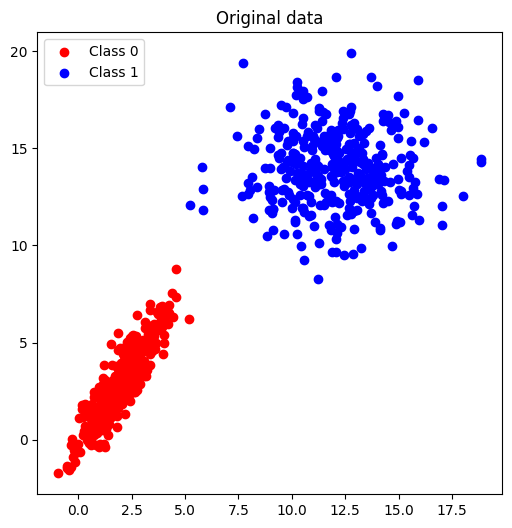

In [ ]:
X0,X1,y = generate_scenario(scenario=1, n_samples0 = 350, n_samples1 = 350)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

## Sanity check: sklearn PCA

Use the following functions from sklearn and scipy to adapt your function and reproduce their behavior. Comment the results.

In [ ]:
from sklearn.decomposition import PCA
from scipy import linalg as LA
from scipy.stats import ortho_group

[0.96522471 0.03477529]


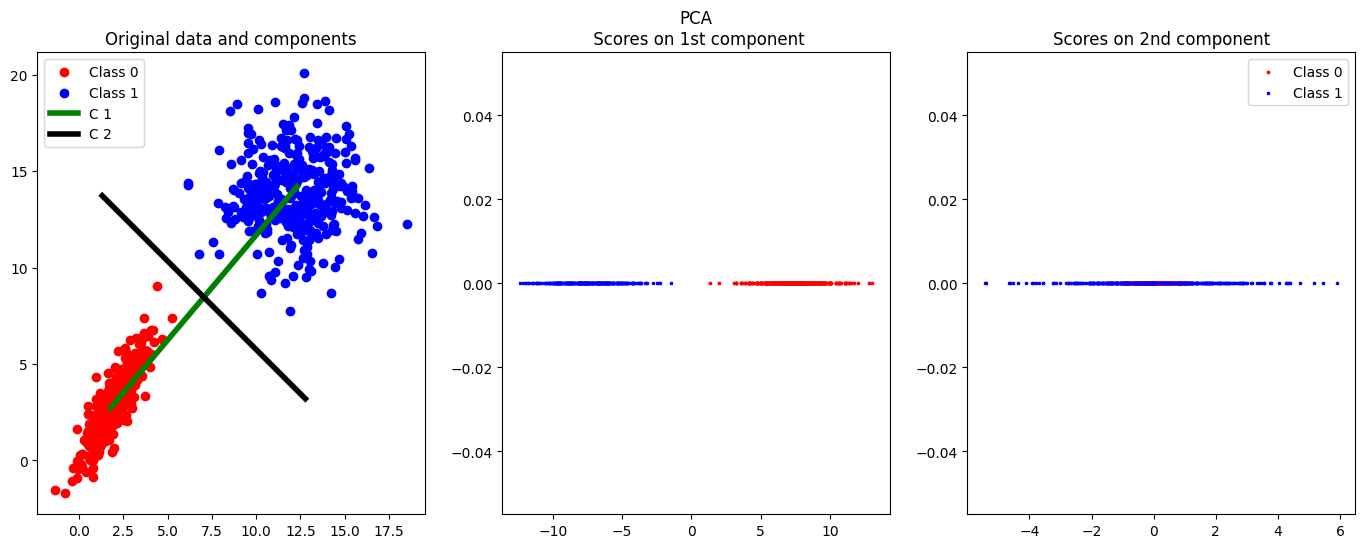

In [ ]:
X0,X1,y = generate_scenario(scenario=1, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

Xc = X - np.mean(X, axis = 0)
## PCA
pca = PCA(random_state=1)
Ypca=pca.fit_transform(Xc)
U=pca.components_.T # we want PC on columns
print(pca.explained_variance_ratio_)
plotResults(X,U,Ypca,const=1,title='PCA')

### Putting everything together

- Select one of the four scenarios that you find convenient

- Select one of the algorithms for binary classification you have learned and implemented along the course

- Train and test your algorithm on the original training set and on the first component of PCA (bonus points if you use your own implementation).

- Empirically measure the time of training and testing and to calculating PCA.

- Plot/print your results. You can choose your own experiments (i.e. decision boundary after classification, average error when repeating the experiment $100$ times, etc...).

- Discuss your results.

In [ ]:
### Test PCA using main function from question 2
z = main(p=1, scenario=1, n_samples0 = 350, n_samples1 = 350)

components.shape : (2, 1)
X_centered.shape : (700, 2)
Data shape before projection : (700, 2)
Data shape after projection : (700, 1)


In [ ]:
### Select an algorithm from previous homeworks and learn on PCA features instead of the original features

#Original data
X0,X1,y = generate_scenario(scenario=1, n_samples0 = 10000, n_samples1 = 10000)
X=np.concatenate((X0,X1),axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#Applying PCA
time_1 = time.time()
X_centered = centerData(X)
print(f'X_centered.shape : {X_centered.shape}')

components = get_PCA(X_centered, p=1)
print(f'components.shape : {components.shape}')

Z = np.dot(X_centered, components)
print(f'Z.shape : {Z.shape}')
time_1 = time.time() - time_1

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(Z, y, test_size=0.30, random_state=42)

print(f'X_train.shape : {X_train.shape}')
print(f'y_train.shape : {y_train.shape}')
print(f'X_train_pca.shape : {X_train_pca.shape}')
print(f'y_train_pca.shape : {y_train_pca.shape}')

X_centered.shape : (20000, 2)
components.shape : (2, 1)
Z.shape : (20000, 1)
X_train.shape : (14000, 2)
y_train.shape : (14000, 1)
X_train_pca.shape : (14000, 1)
y_train_pca.shape : (14000, 1)


In [ ]:
#Training on the original data
clf = svm.SVC()
# clf = LinearRegression()
time_2 = time.time()
clf = clf.fit(X_train,y_train.squeeze())
time_2 = time.time() - time_2
y_pred = clf.predict(X_test)


print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse:.2f}")

print(f"Time for training on original data: {time_2:.2f} seconds")

1.0
[[3017    0]
 [   0 2983]]
Time for training on original data: 0.02 seconds


In [ ]:
#Training and testing on the data after PCA
clf_pca = svm.SVC()
# clf_pca = LinearRegression()
time_3 = time.time()
clf_pca = clf_pca.fit(X_train_pca,y_train_pca.squeeze())
time_3 = time.time() - time_3
y_pred_pca = clf_pca.predict(X_test_pca)

print(accuracy_score(y_test_pca,y_pred_pca))
print(confusion_matrix(y_test_pca,y_pred_pca))

# mse_pca = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse_pca:.2f}")

print(f"Time for PCA: {time_1:.2f} seconds")
print(f"Time for training on data after PCA: {time_3:.2f} seconds")

0.7666666666666667
[[2806  211]
 [1189 1794]]
Time for PCA: 0.01 seconds
Time for training on data after PCA: 6.26 seconds


#*Comments*
After testing with multiple 'n_samples' values, we noticed that the time taken for PCA is consistently longer than the time without PCA, which is counterintuitive. This anomaly arises from the fact that, after PCA, we are left with only one feature. PCA is typically most beneficial when we have a large number of features.

**Answer 3:**

# Part 2: Face recognition


## Question 4:

The goal of this part is to evaluate the performance of the dimensionality reduction technique on an image classification task.

We divide the data-set into two parts, training and test. You will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique.

Compute the scores, eigenvectors and eigenvalues of the training set. The eigenvectors represent the basis images and they are usually called 'Eigenfaces'. Then, project both training and test data onto the eigenvectors that explain 95 %  of the variability of the training set. You will obtain two vectors of scores which you will use for evaluating the performance of the algorithm. Use the function 'KNeighborsClassifier' to test the performance.


Use either the scikit-learn implementation or yours (better!) to compute the PCA for the training data-set. Comment the results.

Is it worth it in your opinion to compute PCA ? Could we simply use pixels as features? Why ?

Hint: think about the performance in your test set and generalizability, the number of operations, etc...

**Answer 4:**

## Downloading data

Load the original images present in the files 'YaleB_32x32.mat'. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot some images using the function 'imshow'.

In [ ]:
# imports
from google_drive_downloader import GoogleDriveDownloader as gdd
import math
import numpy as np
import numpy.matlib

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from scipy import linalg as LA
from scipy.stats import ortho_group

from scipy.io import loadmat

Download data...

In [ ]:
gdd.download_file_from_google_drive(file_id='1tqVweaaKPzI91MumDSHCc_uw2X3xIsCc',
                                    dest_path='./Yale/YaleB_32x32.zip',
                                    unzip=True)

Unzipping...Done.


Below you will find a useful function to plot faces

In [ ]:
def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot


    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))

    nrow=math.ceil(len(indeces)/ncol)

    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())
    #plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

Let's load the data and compute some parameters.

In [ ]:
x = loadmat('./Yale/YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')

Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest=Xtest-np.mean(Xtest,axis=0) # centering
Xctrain=Xtrain-np.mean(Xtrain,axis=0) # centering

There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


Let's plot first 10 images of different subjects and then 10 images of the same subject but with different positions and illumination conditions

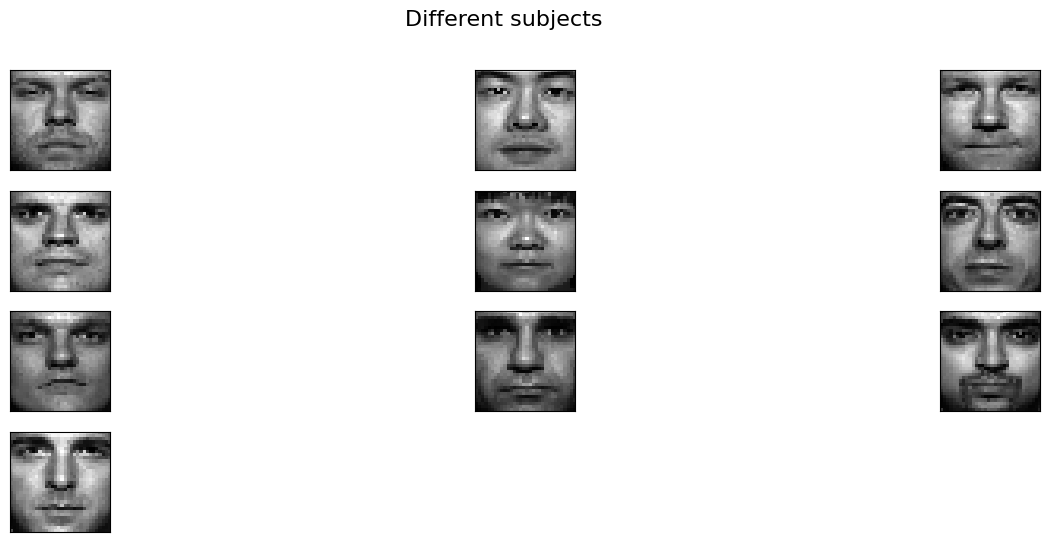

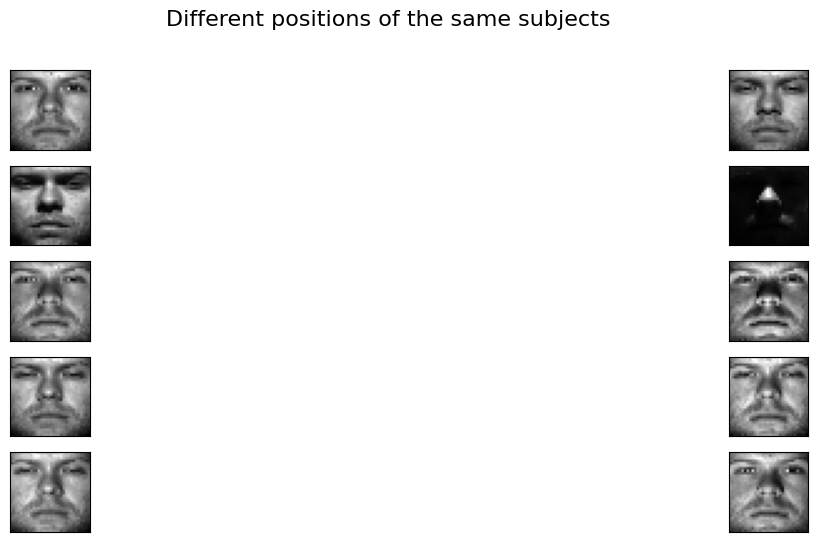

In [ ]:
# Plot data
indexDifferent=np.arange(1,Is*40,Is)
plotFaces(data,r,c,ncol=3,indeces=indexDifferent[0:10],title='Different subjects')
indexSame=np.arange(0,10,1)
plotFaces(data,r,c,ncol=2,indeces=indexSame,title='Different positions of the same subjects')

Preparing data for training/testing:

In [ ]:
# Create train/test split
trainIdx, testIdx = train_test_split(np.arange(0,data.shape[0],1),test_size=0.3,random_state=1)
Xtest=data[testIdx,:]
Xctest=Xtest-np.mean(Xtest,axis=0) # centering
Xtrain=data[trainIdx,:]
Xctrain=Xtrain-np.mean(Xtrain,axis=0) # centering
Id_Train = subjectIndex[trainIdx]; # indeces of the subjects for the training
Id_Test = subjectIndex[testIdx]; # indeces of the subjects for the test

N = Xctrain.shape[0] # N number of training images
M = Xctest.shape[0] # M number of test images

## Pixels as features:

As first idea, we could simply use the pixel intensities as features. This is basically like using the original data, without dimensionality reducton techniques.


In [ ]:
## Use the pixel intensities to find the correct subject for the test images
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Xctrain,Id_Train.ravel())
print('Percentage of correct answer using the pixel intensities is ', NN.score(Xctest,Id_Test))

Percentage of correct answer using the pixel intensities is  0.7324137931034482


## PCA features

Now do the same but with reduced dimensionality. Comment on the execution time, the influence of the number of PCA components.



**Answer:**

In [ ]:
## PCA
print('PCA')
#XXXXXXXXXX

# Threshold defined as 99% of the variability
Threshold_PCA = 99
CumulativePca=np.cumsum(var_explained_pca)
indexPCA=np.argwhere(CumulativePca>Threshold_PCA)
PCAComp=indexPCA[0][0]

# Selection of the eigenvectors
Yr_train_PCA=YpcaTrain[:,:PCAComp]
Ur_train_PCA=UpcaTrain[:,:PCAComp]

# Computation of the test scores using the eigenvectors computed with the
# training data-set
Yr_test_PCA=np.dot(Xctest,Ur_train_PCA)

# Plot the Eigenfaces
plotFaces(UpcaTrain.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='PCA - Eigenfaces')

# Score
NN.fit(Yr_train_PCA,Id_Train.ravel())
print('Percentage of correct answer using PCA is ', NN.score(Yr_test_PCA,Id_Test))

PCA


NameError: ignored

# Part 3: Boosting

We will now take a brief look at a different method for supervised classification.

AdaBoost is an ensemble model that combines "weak learners" (also called stump; a tree with only one node and two leaves) to perform binary classification.

It works by fitting weak decision trees to data in an iterative process where each stump is calculated given the result of a previous iteration.  

The power of the method lies in that some stumps get more say in the final classifications than others as the model attributes weights to each data point according to their "importance."

Samples with higher weights have a higher influence on the total error of the next model and get more priority.

The first stump starts with uniformly distributed weight so that every datapoint has an equal amount of weights.

Each stump is made by taking the previous stump's mistakes into account: After each iteration weights gets re-calculated to take the errors/misclassifications from the last stump into consideration.

The final prediction is typically constructed by a weighted vote where weights for each base model depends on their training errors or misclassification rates.

<img src="https://cdn-images-1.medium.com/max/1600/0*paPv7vXuq4eBHZY7.png" width=700/>

**Figure 2: Iterative process performed by AdaBoost. The size of the labels is proportional to their weight.**

## Question 5: AdaBoost for titanic survival rate.

Here once again you will predict the survival score of a passenger of the titanic disaster.

We will not implement the algorithm but simply use sklearn implementation and analyse the results.

You will choose the prediciton variables $x$ from the available options and apply AdaBoost on it to infer the 'survival' variable.

Here we have two types of variables: Numerical and categorical. For instance, the passenger Age can be an integer $\in [0, 120]$. The passenger class, on the other hand, can only be represented by $3$ values. The passenger sex by $2$ values.


Below are the functions that donwload and preprocess the data.


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import seaborn as sns
sns.set_theme(style="whitegrid")

gdd.download_file_from_google_drive(file_id='1zilQH06ud0nzmmqLUwCnwDHdJkNICBU4',
                                    dest_path='./titanic/data.zip',
                                    unzip=True)
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

# preprocess data

train.drop("Cabin",inplace=True,axis=1)
test.drop("Cabin",inplace=True,axis=1)

train = train[train['Age'].notna()]
test = test[test['Age'].notna()]


train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0],inplace=True)

test['Fare'].fillna(test['Fare'].mean(),inplace=True)

Unzipping...Done.


In [ ]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,S


In [ ]:
test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q


Training data shape:  (714, 11)


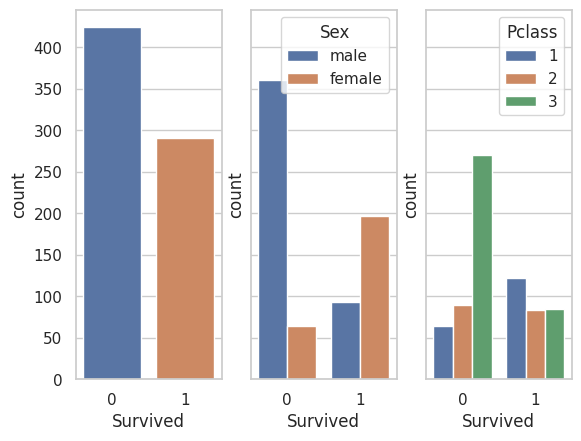

In [ ]:
print('Training data shape: ', train.shape)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
sns.countplot(x = 'Survived',data = train, ax = ax1)
sns.countplot(x = 'Survived',hue = 'Sex',data = train, ax = ax2)
sns.countplot(x = 'Survived',hue = 'Pclass',data = train, ax = ax3)

plt.show()

Apply AdaBoost on the training data to predict if a passenger survived or not given the variables of your choosing (for a good comparison, select the same ones from HW6).

Justify your choices and validate your results using the validation dataset of your choosing (remember to shuffle before spliting the data).

As before, don't "waste" time finetuning your model, this is not a competition. Always remember that we just want to evaluate your understanding of the problem and theory.

**Optional 1:** If you want to compete, you can check the result of your model test prediction on the following kaggle challenge:

https://www.kaggle.com/c/titanic/data

You have to export the data on the corresponding data format.

**Optional 2:** Apply kfold croos validation to the problem and discuss the results.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
scaler = StandardScaler()
# Example of training set
x_train = np.concatenate(((train['Age']).to_numpy()[:, None], (train['Pclass']).to_numpy()[:, None], (train['Sex'].replace(['male', 'female'], [0,1]).to_numpy()[:, None])), axis = 1)
x_train = scaler.fit_transform(x_train)

y_train = train['Survived'].to_numpy(int)


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.75)

# Test set
x_test = np.concatenate(((test['Age']).to_numpy()[:, None], (test['Pclass']).to_numpy()[:, None], (test['Sex'].replace(['male', 'female'], [0,1]).to_numpy()[:, None])), axis = 1)

In [ ]:
y_pred_train = np.zeros(y_train.shape)
y_pred_val = np.zeros(y_val.shape)
y_pred_test = np.zeros(x_test.shape[0])

In [ ]:
def logResTest(Y, Y_pred):
  """
  Test the SVM Model

  Parameters:
  -----------
  `W` : Trained weights [d x 1]
  `X` : Testing inputs [d x N]
  `Y` : Testing Labels [1 x N]

  Returns:
  --------
  `A` : Accuracy
  `P` : Precision
  `R` : Recall

  """
  N = len(X[0])


  A = np.mean(Y_pred == Y.T[0])


  P = np.sum(np.logical_and(Y_pred == Y, Y_pred == 1)) / np.sum(Y_pred)
  R = np.sum(np.logical_and(Y_pred == Y, Y_pred == 1)) / np.sum(Y)

  return A, P, R

In [ ]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
y_val_pred = clf.predict(x_val)
y_train_pred = clf.predict(x_train)

logResTest(y_val, y_val_pred)



[0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0
 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0
 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1
 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0
 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0
 1 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0
 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1
 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1
 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0
 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0
 1 1 1 0 0 0 1 0 1 0 0 0 

Print the Confusion matrix of your prediction

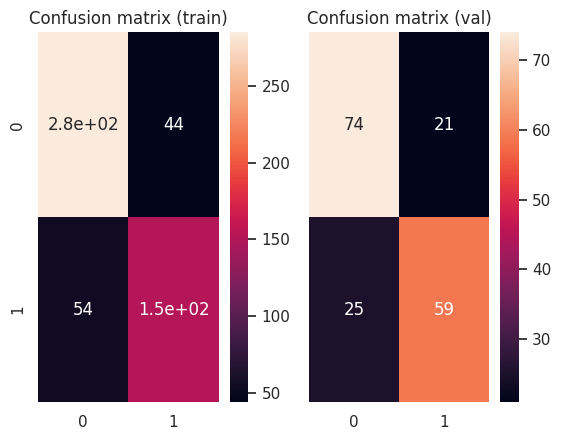

In [ ]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cf_matrix_train = confusion_matrix(y_train, y_train_pred)


# Get the confusion matrix
cf_matrix_test = confusion_matrix(y_val, y_val_pred)

# Plot with sns

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.heatmap(cf_matrix_train, annot=True, ax = ax1).set(title='Confusion matrix (train)')
sns.heatmap(cf_matrix_test, annot=True, ax = ax2).set(title='Confusion matrix (val)')


plt.show()

## Question 6:

Discuss and compare AdaBoost results with Logistic Regression from HW6. Which method is more adapted to the Titanic survival rate problem? Why?

**Answer :**

When we look at the metrics Precision and Recall and the confusion matrix we see that the results with adaboost are slightly better than with classic regression. It's logical since adaboost is suppose to improve performace on small dataset. However the differece might not be worth the time needed to compute adaboost istead of regression.


# References :
- Chapter 10 of the book : Understanding Machine Learning
- Chapter 23 of the book : Understanding Machine Learning


# Comments of the students:

To improve the experience of students that will take the course on the future any thoughtful comment or suggestion will be much appreciated!

**Comments:**